In [1558]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PROJEKT
## GOOGLE STORE RATING
### Katarzyna Sobczyszyn

In [1559]:
import os
data =  pd.read_csv(os.path.join("googleplaystore.csv"))
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## OPIS DANYCH

In [1560]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


## OBRÓBKA DANYCH

### Niepotrzebne kolumny i null wartości

In [1561]:
cols = ['App','Current Ver','Genres','Size','Android Ver']
print("Usuwam kolumnę unikalnych wartości 'App' ")
print("Usuwam kolumnę 'Current Ver' bo liczba kategorii to : ", data['Current Ver'].nunique())
print("Usuwam kolumnę 'Genres' bo jest to poszerzona kategoria kolumny 'Category'")
print("Usuwam kolumnę 'Size' bo zawiera :",len(data.loc[data['Size'] =='Varies with device']),"nieprecyzyjnych danych")
print("Usuwam kolumnę 'Android Ver' bo zawiera :",len(data.loc[data['Android Ver'] =='Varies with device']),"nieprecyzyjnych danych")
data = data[data['Content Rating'].isin(['Adults only 18+','Unrated']) == False]
data = data.drop(cols, axis=1)
data.dropna(inplace= True)
print('Liczba aplikacji : ' , len(data))
data.head()

Usuwam kolumnę unikalnych wartości 'App' 
Usuwam kolumnę 'Current Ver' bo liczba kategorii to :  2832
Usuwam kolumnę 'Genres' bo jest to poszerzona kategoria kolumny 'Category'
Usuwam kolumnę 'Size' bo zawiera : 1695 nieprecyzyjnych danych
Usuwam kolumnę 'Android Ver' bo zawiera : 1362 nieprecyzyjnych danych
Liczba aplikacji :  9362


,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Last Updated
0,ART_AND_DESIGN,4.1,159,"10,000+",Free,0,Everyone,"January 7, 2018"
1,ART_AND_DESIGN,3.9,967,"500,000+",Free,0,Everyone,"January 15, 2018"
2,ART_AND_DESIGN,4.7,87510,"5,000,000+",Free,0,Everyone,"August 1, 2018"
3,ART_AND_DESIGN,4.5,215644,"50,000,000+",Free,0,Teen,"June 8, 2018"
4,ART_AND_DESIGN,4.3,967,"100,000+",Free,0,Everyone,"June 20, 2018"


### Poprawki

#### Zmieniam 'Last Updated' na rok (int)

In [1562]:
print("We wszystkich aplikacjach 'Last Updated' kończy się 4 cyfrową liczbą (rokiem) :", len(data[data['Last Updated'].str.match('.*, [0-9]{4}$') ==False]) ==0 )
data['Last Updated'] = data['Last Updated'].str[-4:]
print("Teraz liczba kategorii w kolumnie 'Last Updated' : ", data['Last Updated'].nunique())
data['Last Updated'] = data['Last Updated'].astype('int')

We wszystkich aplikacjach 'Last Updated' kończy się 4 cyfrową liczbą (rokiem) : True
Teraz liczba kategorii w kolumnie 'Last Updated' :  9


#### Zmieniam 'Price' by była liczbą (usuwam '$')

In [1563]:
print("Wszystkie aplikacje w których 'Price' nie jest liczbą, rozpoczynają się '$' :", len(data[data['Price'].str.match('^\\$[0-9\\.]+$')])==len(data[data['Price'].str.match('^[0-9\\.]+$') ==False]))
data.loc[data['Price']!='0',['Price']]= data['Price'].str[1:]
print("Po poprawie liczba aplikacji w których 'Price' nie jest liczbą :", len(data[data['Price'].str.match('^[0-9\\.]+$')==False]))
data['Price'] = data['Price'].astype('float')

Wszystkie aplikacje w których 'Price' nie jest liczbą, rozpoczynają się '$' : True
Po poprawie liczba aplikacji w których 'Price' nie jest liczbą : 0


In [1564]:
data['Reviews'] = data['Reviews'].astype('int')

### PO OBRÓBCE

In [1565]:
data.head()

,Category,Rating,Reviews,Installs,Type,Price,Content Rating,Last Updated
0,ART_AND_DESIGN,4.1,159,"10,000+",Free,0.0,Everyone,2018
1,ART_AND_DESIGN,3.9,967,"500,000+",Free,0.0,Everyone,2018
2,ART_AND_DESIGN,4.7,87510,"5,000,000+",Free,0.0,Everyone,2018
3,ART_AND_DESIGN,4.5,215644,"50,000,000+",Free,0.0,Teen,2018
4,ART_AND_DESIGN,4.3,967,"100,000+",Free,0.0,Everyone,2018


In [1566]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9362 entries, 0 to 10840
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        9362 non-null   object 
 1   Rating          9362 non-null   float64
 2   Reviews         9362 non-null   int64  
 3   Installs        9362 non-null   object 
 4   Type            9362 non-null   object 
 5   Price           9362 non-null   float64
 6   Content Rating  9362 non-null   object 
 7   Last Updated    9362 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 916.3+ KB


In [1567]:
import seaborn as sns

## Rating

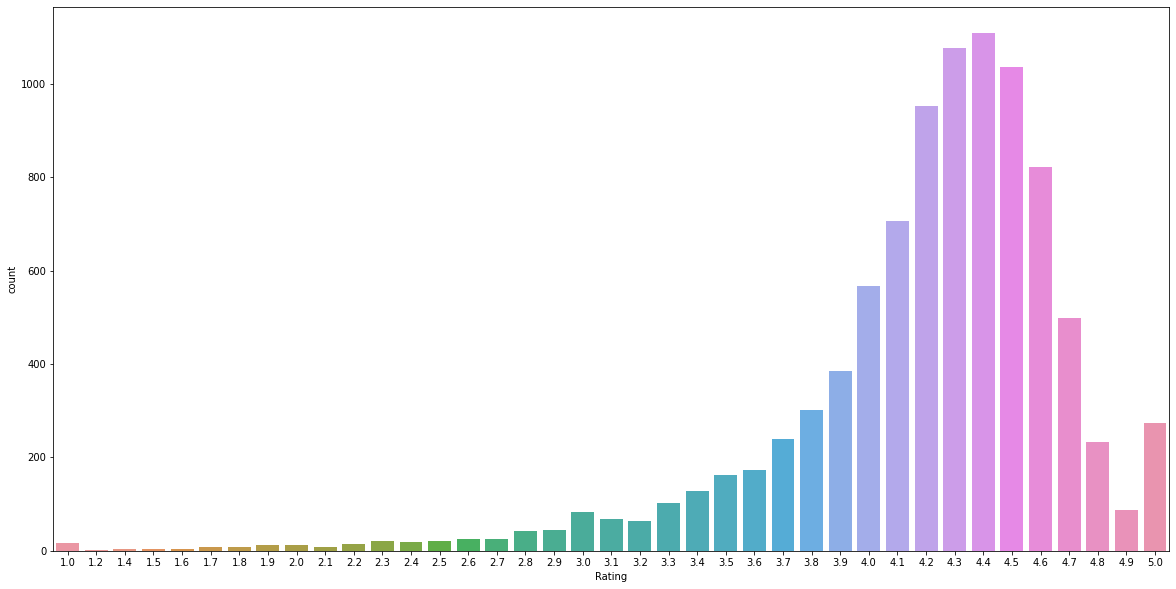

In [1568]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'Rating' ,data=data)
plt.show()

## Installs

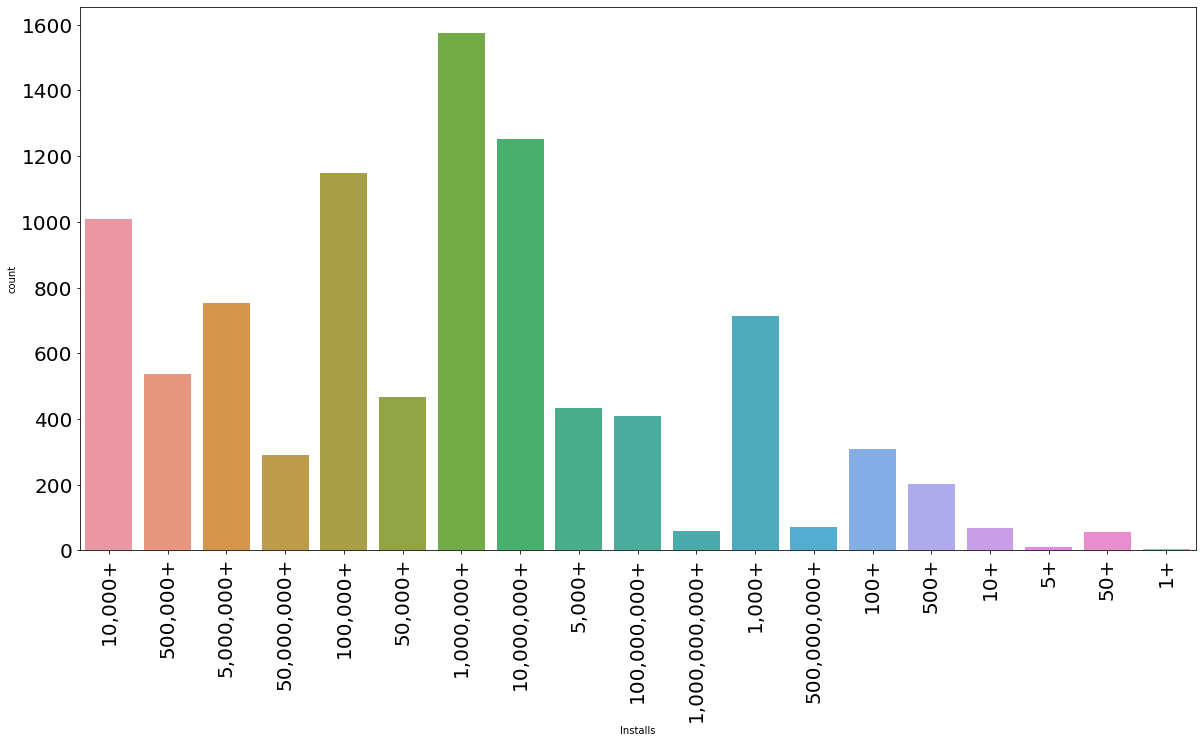

In [1569]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'Installs' ,data=data)
plt.yticks(fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.show()

## Category

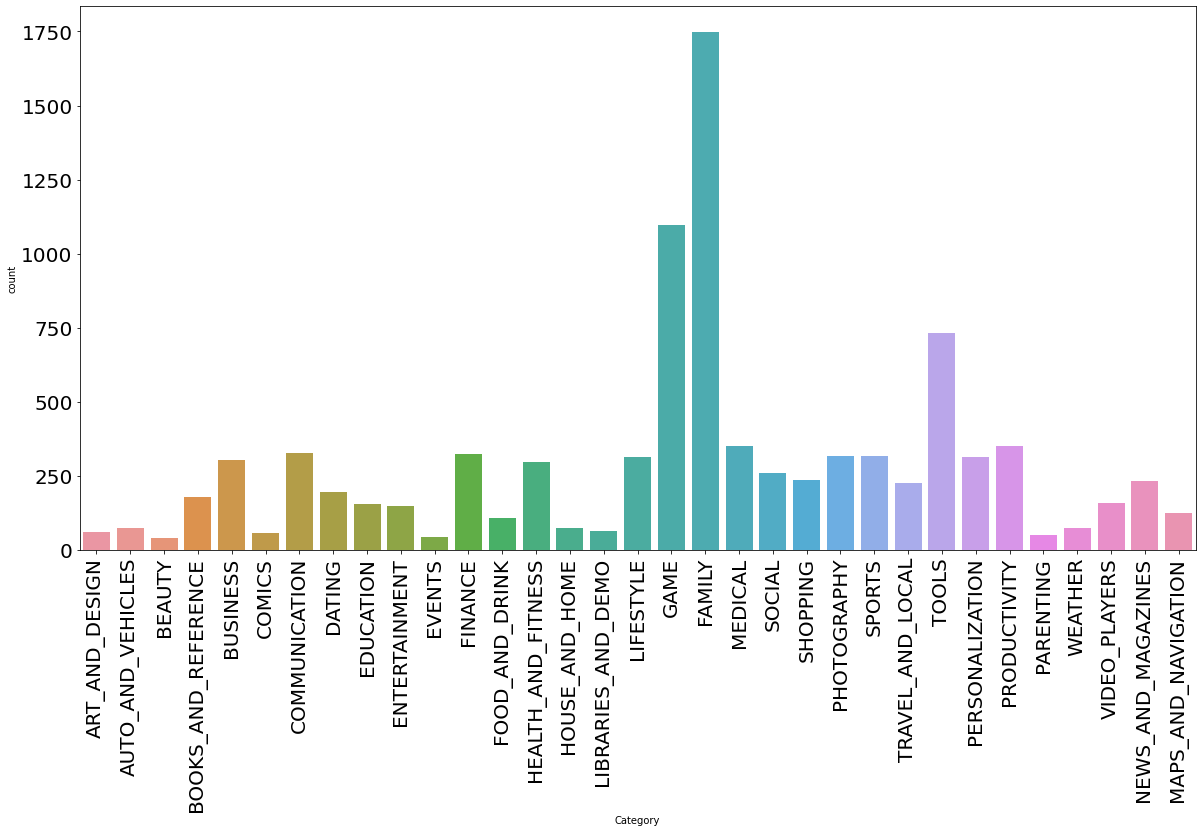

In [1570]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'Category' ,data=data)
plt.yticks(fontsize = 20)
plt.xticks(rotation = 90, fontsize = 20)
plt.show()

## Type

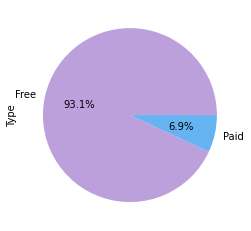

Type                 Free        Paid
Rating count  8715.000000  647.000000
       mean      4.186173    4.266615
       std       0.512408    0.547523
       min       1.000000    1.000000
       25%       4.000000    4.100000
       50%       4.300000    4.400000
       75%       4.500000    4.600000
       max       5.000000    5.000000

In [1571]:
data['Type'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['#bca0dc','#66b3f1'])
plt.show()
data.groupby('Type').describe()[['Rating']].T

## Content rating

Content Rating     Everyone  Everyone 10+  Mature 17+         Teen
Rating count    7420.000000    397.000000  461.000000  1084.000000
       mean        4.186375      4.257179    4.123427     4.233487
       std         0.537377      0.367259    0.505765     0.391595
       min         1.000000      1.800000    1.000000     2.000000
       25%         4.000000      4.100000    4.000000     4.000000
       50%         4.300000      4.300000    4.200000     4.300000
       75%         4.500000      4.500000    4.400000     4.500000
       max         5.000000      5.000000    5.000000     5.000000

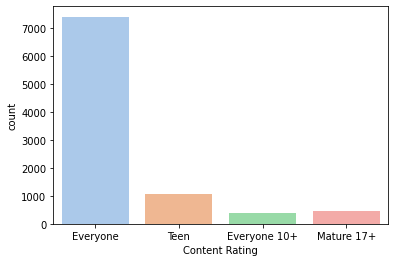

In [1572]:
sns.countplot(x='Content Rating',data=data,palette='pastel')
data.groupby('Content Rating').describe()[['Rating']].T